# FISH - Data interpretation - A Python interactive notebook to interpret FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.

```

## Importing libraries

In [1]:
import sys
import matplotlib.pyplot as plt 
from  matplotlib.ticker import FuncFormatter
import numpy as np 
import pandas as pd
import pathlib
import warnings
import glob
import seaborn as sns
import zipfile
import shutil
import scipy.stats as stats
import os
warnings.filterwarnings("ignore")

## Defining paths

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')
# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa
# Local folder path
local_folder_path = pathlib.Path().absolute().joinpath('temp_zip_analyses')
local_folder_path
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
# Connection to munsky-nas
path_to_config_file = desktop_path.joinpath('config.yml')
share_name = 'share'

# creating a folder to store all plots
destination_folder = pathlib.Path().absolute().joinpath('results', 'data_Huy')
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder) 

In [3]:
psf_z=350                # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers
psf_yx=160               # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers
voxel_size_z=500         # Microscope conversion px to nanometers in the z axis.
voxel_size_yx=160        # Microscope conversion px to nanometers in the xy axis.
scale = np.array ([ voxel_size_z/psf_z, voxel_size_yx/psf_yx, voxel_size_yx/psf_yx ])

list_timepoints = [0,18,300]
list_thresholds_intensity =[400,450,500,550]
list_thresholds_distance=[1,2,3]

In [4]:
def extract_spot_classification_from_df(df,show_plots = False,time_point=0,threshold_intensity=0,threshold_distance=0):
    number_cells = df['cell_id'].nunique()
    array_spot_type_per_cell = np.zeros((number_cells, 10)).astype(int) # this array will store the spots separated  as types: spot_0_only, spot_1_only, or spot_0_1
    for cell_id in range(number_cells):
        # retrieving the coordinates for spots type 0 and 1 for each cell 
        array_spots_0 = np.asarray( df[['z','y','x']][(df["cell_id"] == cell_id) & (df["spot_type"] == 0)] ) # coordinates for spot_type_0 with shape [num_spots_type_0, 3]
        array_spots_1 = np.asarray( df[['z','y','x']][(df["cell_id"] == cell_id) & (df["spot_type"] == 1)] ) # coordinates for spot_type_1 with shape [num_spots_type_1, 3]
        total_spots0 = array_spots_0.shape[0]
        total_spots1 = array_spots_1.shape[0]
        # Concatenating arrays from spots 0 and 1
        array_all_spots = np.concatenate((array_spots_0,array_spots_1), axis=0) 
        # Calculating a distance matrix. 
        distance_matrix = np.zeros( (array_all_spots.shape[0], array_all_spots.shape[0])) #  the distance matrix is an square matrix resulting from the concatenation of both spot  types.
        for i in range(len(array_all_spots)):
            for j in range(len(array_all_spots)):
                if j<i:
                    distance_matrix[i,j] = np.linalg.norm( ( array_all_spots[i,:]-array_all_spots[j,:] ) * scale )
        # masking the distance matrix. Ones indicate the distance is less or equal than threshold_distance
        mask_distance_matrix = (distance_matrix <= threshold_distance) 
        # Selecting the right-lower quadrant as a subsection of the distance matrix that compares one spot type versus the other. 
        subsection_mask_distance_matrix = mask_distance_matrix[total_spots0:, 0:total_spots0].copy()
        if show_plots == True:
            plt.imshow(mask_distance_matrix, cmap='Greys_r')
            plt.imshow(subsection_mask_distance_matrix,cmap='Greys_r')
        # Calculating each type of spots in cell
        is_spot_only_type_0 = np.all(~subsection_mask_distance_matrix, axis =1 ) # Testing if all the columns are ones of inv(subsection_mask_distance_matrix). Representing spot type 0.
        is_spot_only_type_1 = np.all(~subsection_mask_distance_matrix, axis =0 ) #  Testing if all the rows are ones of inv(subsection_mask_distance_matrix). Representing spot type 1.
        num_type_0_only = np.sum(is_spot_only_type_0) 
        num_type_1_only =np.sum(is_spot_only_type_1) 
        num_type_0_1 = (total_spots0 - num_type_0_only) + (total_spots1 - num_type_1_only) # Number of spots in both channels
        array_spot_type_per_cell[cell_id,:] = np.array([time_point, threshold_intensity,threshold_distance, cell_id, num_type_0_only, num_type_1_only, num_type_0_1, num_type_0_only+num_type_0_1, 
                                                        num_type_1_only+num_type_0_1, num_type_0_only+num_type_1_only+num_type_0_1]).astype(int)
        list_labels = ['time','ts_intensity','ts_distance','cell_id','num_0_only','num_1_only','num_0_1','num_0', 'num_1','total']
        # creating a dataframe
        df_spots_classification = pd.DataFrame(data=array_spot_type_per_cell, columns=list_labels)
    return df_spots_classification  


## List of folders to process

In [5]:
def Huy_data(mandatory_substring):
    list_dirs=(
    'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim',
    'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_18minTPL_5uM' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_5hTPL_5uM' )
    list_labels = [ 'woSTM','18minTPL_5uM','5hTPL_5uM']
    plot_title_suffix= "MS2_CY5"
    mandatory_substring = mandatory_substring      #'nuc_70__cyto_0__psfz_350__psfyx_160__ts_400_400'
    return list_dirs, list_labels, plot_title_suffix, mandatory_substring

----

# Running the codes

----

In [ ]:
substring_to_iterate = 'nuc_70__cyto_0__psfz_350__psfyx_160__ts_'

In [ ]:
# Code to iterate for a given time point.
# 

In [6]:
substrings =[
    'nuc_70__cyto_0__psfz_350__psfyx_160__ts_400_400',
    'nuc_70__cyto_0__psfz_350__psfyx_160__ts_450_450',
    'nuc_70__cyto_0__psfz_350__psfyx_160__ts_500_500',
    'nuc_70__cyto_0__psfz_350__psfyx_160__ts_550_550' ]

## Connecting to NAS and extracting data

In [7]:
list_df_paths=[]
list_df_names=[]
counter_dataframes =0

for k, ts_distance in enumerate(list_thresholds_distance):
    for j,mandatory_substring in enumerate(substrings):
        list_dirs, list_labels, plot_title_suffix, mandatory_substring = Huy_data(mandatory_substring=mandatory_substring)
        list_local_files = fa.Utilities.read_zipfiles_from_NAS(list_dirs,path_to_config_file,share_name, mandatory_substring, local_folder_path)
        list_local_folders = fa.Utilities.unzip_local_folders(list_local_files,local_folder_path)
        list_dataframes = fa.Utilities.extracting_data_for_each_df_in_directory(  list_local_folders=list_local_folders,current_dir=current_dir,minimal_TS_size=2)[6]
        # Iterating for each time point (experimental condition)
        for i,tp in enumerate (list_timepoints):
            df_spots_classification = extract_spot_classification_from_df(df=list_dataframes[i],show_plots = False, time_point=tp, threshold_intensity = list_thresholds_intensity[j],threshold_distance=ts_distance )
            df_name = plot_title_suffix+'_time_'+str(tp)+ '_int_'+str(list_thresholds_intensity[j])+ '_dist_'+str(ts_distance)
            df_path=pathlib.Path().absolute().joinpath(destination_folder,df_name +'.csv')
            df_spots_classification.to_csv(df_path, index = False)
            df_spots_classification = ""
            list_df_paths.append(df_path)
            list_df_names.append(df_name)
            counter_dataframes+=1
        del list_dirs, list_labels, plot_title_suffix, mandatory_substring, list_local_files,list_local_folders,list_dataframes,df_path,df_name


Connection established
Connection established
Files downloaded to: /home/luisub/Desktop/FISH_Processing/notebooks/temp_zip_analyses/analysis_MS2-CY5_Cyto543_560_woStim___nuc_70__cyto_0__psfz_350__psfyx_160__ts_400_400.zip
Connection established
Connection established
Files downloaded to: /home/luisub/Desktop/FISH_Processing/notebooks/temp_zip_analyses/analysis_MS2-CY5_Cyto543_560_18minTPL_5uM___nuc_70__cyto_0__psfz_350__psfyx_160__ts_400_400.zip
Connection established
Connection established
Files downloaded to: /home/luisub/Desktop/FISH_Processing/notebooks/temp_zip_analyses/analysis_MS2-CY5_Cyto543_560_5hTPL_5uM___nuc_70__cyto_0__psfz_350__psfyx_160__ts_400_400.zip
Connection established
Connection established
Files downloaded to: /home/luisub/Desktop/FISH_Processing/notebooks/temp_zip_analyses/analysis_MS2-CY5_Cyto543_560_woStim___nuc_70__cyto_0__psfz_350__psfyx_160__ts_450_450.zip
Connection established
Connection established
Files downloaded to: /home/luisub/Desktop/FISH_Processing

In [8]:
# Loading all dataframes in a dictionary
dic_dataframes = {}
for df_index, df_name in enumerate (list_df_names):
    dic_dataframes[df_name] = pd.read_csv(list_df_paths[df_index])


In [9]:
list_df_names

['MS2_CY5_time_0_int_400_dist_1',
 'MS2_CY5_time_18_int_400_dist_1',
 'MS2_CY5_time_300_int_400_dist_1',
 'MS2_CY5_time_0_int_450_dist_1',
 'MS2_CY5_time_18_int_450_dist_1',
 'MS2_CY5_time_300_int_450_dist_1',
 'MS2_CY5_time_0_int_500_dist_1',
 'MS2_CY5_time_18_int_500_dist_1',
 'MS2_CY5_time_300_int_500_dist_1',
 'MS2_CY5_time_0_int_550_dist_1',
 'MS2_CY5_time_18_int_550_dist_1',
 'MS2_CY5_time_300_int_550_dist_1',
 'MS2_CY5_time_0_int_400_dist_2',
 'MS2_CY5_time_18_int_400_dist_2',
 'MS2_CY5_time_300_int_400_dist_2',
 'MS2_CY5_time_0_int_450_dist_2',
 'MS2_CY5_time_18_int_450_dist_2',
 'MS2_CY5_time_300_int_450_dist_2',
 'MS2_CY5_time_0_int_500_dist_2',
 'MS2_CY5_time_18_int_500_dist_2',
 'MS2_CY5_time_300_int_500_dist_2',
 'MS2_CY5_time_0_int_550_dist_2',
 'MS2_CY5_time_18_int_550_dist_2',
 'MS2_CY5_time_300_int_550_dist_2',
 'MS2_CY5_time_0_int_400_dist_3',
 'MS2_CY5_time_18_int_400_dist_3',
 'MS2_CY5_time_300_int_400_dist_3',
 'MS2_CY5_time_0_int_450_dist_3',
 'MS2_CY5_time_18_int

In [11]:
# calculate average number of both spots at time 0
print(dic_dataframes['MS2_CY5_time_0_int_400_dist_1']['num_0_1'].values.mean())
print(dic_dataframes['MS2_CY5_time_0_int_450_dist_1']['num_0_1'].values.mean())
print(dic_dataframes['MS2_CY5_time_0_int_500_dist_1']['num_0_1'].values.mean())
print(dic_dataframes['MS2_CY5_time_0_int_550_dist_1']['num_0_1'].values.mean())


47.019354838709674
45.329032258064515
43.10967741935484
40.16774193548387


In [ ]:
# Loading the data

In [14]:
list_df_paths=[]
list_df_names=[]
counter_dataframes =0
plot_title_suffix= "MS2_CY5"
for k, ts_distance in enumerate(list_thresholds_distance):
    for j,mandatory_substring in enumerate(substrings):
        # Iterating for each time point (experimental condition)
        for i,tp in enumerate (list_timepoints):
            df_name = plot_title_suffix+'_time_'+str(tp)+ '_int_'+str(list_thresholds_intensity[j])+ '_dist_'+str(ts_distance)
            df_path=pathlib.Path().absolute().joinpath(destination_folder,df_name +'.csv')
            list_df_paths.append(df_path)
            list_df_names.append(df_name)
            counter_dataframes+=1
# Loading all dataframes in a dictionary
dic_dataframes = {}
for df_index, df_name in enumerate (list_df_names):
    dic_dataframes[df_name] = pd.read_csv(list_df_paths[df_index])


In [34]:
matrix_number_spots_time_0 = np.zeros( (len(list_thresholds_intensity),len(list_thresholds_distance)) )
for int, ts_intensity in enumerate(list_thresholds_intensity):
    for d, ts_distance in enumerate(list_thresholds_distance):
        df_name_loop = 'MS2_CY5_time_0_int_'+str(ts_intensity)+'_dist_'+str(ts_distance)
        matrix_number_spots_time_0[int, d] = np.round( dic_dataframes[df_name_loop]['num_0_1'].values.mean(), 0)
matrix_number_spots_time_0


array([[185., 199., 207.],
       [172., 186., 194.],
       [165., 178., 186.],
       [161., 173., 180.]])

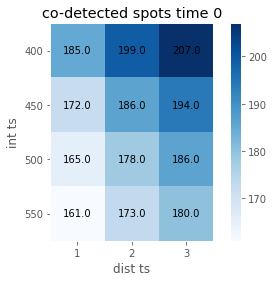

In [61]:
fig, ax = plt.subplots(1,1)
img = ax.imshow(matrix_number_spots_time_0,cmap='Blues')
for (j,i),label in np.ndenumerate(matrix_number_spots_time_0):
    ax.text(i,j,label,ha='center',va='center')
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2])
ax.set_xticklabels(list_thresholds_distance)
ax.set_yticklabels(list_thresholds_intensity)
ax.set_xlabel('dist ts')
ax.set_ylabel('int ts')
ax.set_title('co-detected spots time 0')
fig.colorbar(img)
plt.grid(None)
plt.show()

In [29]:
matrix_number_spots_tme_18 = np.zeros( (len(list_thresholds_intensity),len(list_thresholds_distance)) )
for int, ts_intensity in enumerate(list_thresholds_intensity):
    for d, ts_distance in enumerate(list_thresholds_distance):
        df_name_loop = 'MS2_CY5_time_18_int_'+str(ts_intensity)+'_dist_'+str(ts_distance)
        matrix_number_spots_tme_18[int, d] = np.round( dic_dataframes[df_name_loop]['num_0_1'].values.mean(), 0)
matrix_number_spots_tme_18

array([[142., 151., 157.],
       [130., 138., 143.],
       [123., 129., 133.],
       [119., 124., 127.]])

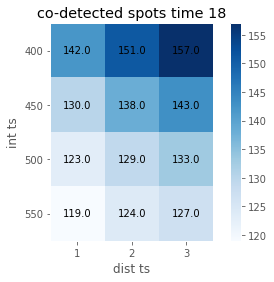

In [59]:
fig, ax = plt.subplots(1,1)
img = ax.imshow(matrix_number_spots_tme_18,cmap='Blues')
for (j,i),label in np.ndenumerate(matrix_number_spots_tme_18):
    ax.text(i,j,label,ha='center',va='center')
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2])
ax.set_xticklabels(list_thresholds_distance)
ax.set_yticklabels(list_thresholds_intensity)
ax.set_xlabel('dist ts')
ax.set_ylabel('int ts')
ax.set_title('co-detected spots time 18')
fig.colorbar(img)
plt.grid(None)
plt.show()

In [30]:
matrix_number_spots_tme_300 = np.zeros( (len(list_thresholds_intensity),len(list_thresholds_distance)) )
for int, ts_intensity in enumerate(list_thresholds_intensity):
    for d, ts_distance in enumerate(list_thresholds_distance):
        df_name_loop = 'MS2_CY5_time_300_int_'+str(ts_intensity)+'_dist_'+str(ts_distance)
        matrix_number_spots_tme_300[int, d] = np.round( dic_dataframes[df_name_loop]['num_0_1'].values.mean(), 0)
matrix_number_spots_tme_300

array([[97., 97., 98.],
       [90., 90., 90.],
       [89., 89., 89.],
       [91., 91., 91.]])

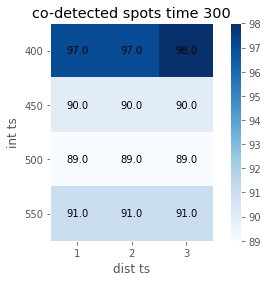

In [60]:
fig, ax = plt.subplots(1,1)
img = ax.imshow(matrix_number_spots_tme_300,cmap='Blues')
for (j,i),label in np.ndenumerate(matrix_number_spots_tme_300):
    ax.text(i,j,label,ha='center',va='center')
ax.set_yticks([0,1,2,3])
ax.set_xticks([0,1,2])
ax.set_xticklabels(list_thresholds_distance)
ax.set_yticklabels(list_thresholds_intensity)
ax.set_xlabel('dist ts')
ax.set_ylabel('int ts')
ax.set_title('co-detected spots time 300')
fig.colorbar(img)
plt.grid(None)
plt.show()